Last time on the blog, we were looking at the paper "<b style="color:#EB1960">A living biobank of ovarian cancer ex vivo models reveals profound mitotic heterogeneity</b>" [@ovarian-cancer-living-biobank].  We'll pick up where we left off, this time trying to recreate <b style="color:#EB1960">Figure 5</b>.

![<b style="color:#EB1960">Figure 5</b>.  Not my own work](./images/ovarian-fig5.png)

<details>
    <summary><b class="setups">Recap</b><b style="color:#C0CF96">: Loading the Data</b></summary>

In [ ]:
file.path = './localdata/E-MTAB-8559-quantification-raw-files/'

In [ ]:
# Load in the matrix of expected raw counts
raw.counts <- Matrix::readMM(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx',
        sep=''
    )
)


# Load in the row names (genes)
row.info <- read.table(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx_rows',
        sep=''
    ),
    header=FALSE,
    col.names=c("Ensembl.ID", "Redundant")
)

if (all(row.info['Ensembl.ID'] != row.info['Redundant'])) {
    # I don't understand why these datasets tend to write
    # the same name twice in each row???
    print("Warning: second column is not actually redundant!")
}

# Drop duplicate column from genes
row.info <- row.info['Ensembl.ID']

# Load in the column names (single cells)
col.info <- read.table(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx_cols',
        sep=''
    ),
    header=FALSE,
    sep='-',
    col.names=c('Sample.Info', 'Cell.Barcode')
)
col.info['Full.ID'] <- apply(
    col.info,
    1, # Rows
    function(row) {
    paste(
        row['Sample.Info'],
        row['Cell.Barcode'],
        sep='-'
    )
})

# Load in the experimental design matrix
exp.design.table <- read.table(
    './localdata/ExpDesign-E-MTAB-8559.tsv',
    header=TRUE,
    sep='\t'
)

</details>

# <b style="color:#537FBF">Filtering</b> and <b style="color:#537FBF">Normalization</b>

In [ ]:
dim(raw.counts)

[1] 23284 19880

There are 23,284 genes and 19,880 cells - which is quite a lot!  So we should probably <b style="color:#537FBF">filter</b> some things out.

> We used three measures to identify and remove the low-quality cells. Namely, the <strong style="color:#A6A440">library size</strong>; the <strong style="color:#C0CF96">number of expressed genes</strong>; and <strong style="color:#C0CF96">the proportion of reads mapped to mitochondrial genes</strong> in all four samples. Cells exhibiting a library size lower than three <b style="color:#A6A440">Median Absolute Deviations</b> (<b style="color:#A6A440">MAD</b>) were <b style="color:#537FBF">filtered</b> out. Also, cells expressing a gene count lower than three <b style="color:#A6A440">MAD</b> were filtered out. For mitochondrial read proportions, we filtered out the cells that displayed a percentage of reads mapping to mitochondrial genes greater than three <b style="color:#A6A440">MAD</b>.

## <b style="color:#A6A440">Library Size</b> <b style="color:#537FBF">Filtering</b>

In [ ]:
library.sizes <- Matrix::colSums(raw.counts)

In [ ]:
library.median.size <- median(library.sizes)
median.absolute.deviation <- median(abs(library.sizes - library.median.size))
library.lower.bound <- library.median.size - 3*median.absolute.deviation
any(library.sizes < library.lower.bound)

[1] FALSE

It seems that none of the cells have a sufficiently low <b style="color:#A6A440">library size</b> to be <b style="color:#537FBF">filtered out</b>.

## <b style="color:#A6A440">Gene Count</b> <b style="color:#537FBF">Filtering</b>

In [ ]:
gene.counts <- Matrix::colSums(raw.counts > 0)

In [ ]:
gene.median.counts <- median(gene.counts)
median.absolute.deviation <- median(abs(gene.counts - gene.median.counts))
gene.lower.bound <- gene.median.counts - 3*median.absolute.deviation
gene.filter.index <- gene.counts < gene.lower.bound
any(gene.filter.index)

[1] TRUE

In [ ]:
sum(gene.filter.index)

[1] 557

We'll <b style="color:#537FBF">filter out</b> these 557 cells.

In [ ]:
# gf for gene filtering
filtered.counts.gf <- raw.counts[, !gene.filter.index]
filtered.row.info.gf <- row.info
filtered.col.info.gf <- col.info[!gene.filter.index, ]

## Mitochondrial <b style="color:#537FBF">Filtering</b>

For this we'll use the `biomart` package.

<details>
    <summary><b class="setups">Install</b><b style="color:#C0CF96">: biomaRt</b></summary>
    
```{bash}
conda search bioconda::r-biomart
conda install bioconda::bioconductor-biomart=2.54.0 -y
```

This is the first time I've had to use the `bioconda` channel, but [their website](https://bioconda.github.io/#:~:text=The%20bioconda%20channel%20enables%20installation,is%20set%20to%20highest%20priority.) clearly shows they're built on top of `conda-forge` so I know I'm not going to get burned by channel conflicts as has happened before.  Unfortunately it doesn't work, all versions of `biomart` have dependency conflicts somewhere (so maybe I have been burned by channel conflicts...)
    
So now I will install `biocmanager` and install it the in-R way.
    
```{bash}
# Bash
conda search conda-forge::r-biocmanager
conda install conda-forge::r-biocmanager=1.30.19 -y
```
    
```{R}
# R
BiocManager::install("biomaRt")
```

</details>

In [ ]:
library("biomaRt")

In [ ]:
# Configure biomart to use human info (as opposed to other species)
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))

gene.to.symbol.map <- getBM(
    filters="ensembl_gene_id",
    attributes=c(
        "ensembl_gene_id",
        "hgnc_symbol"
    ),
    values=filtered.row.info.gf$Ensembl.ID,
    mart=mart
)

Annoyingly, `getBM` silently drops IDs when it can't find a matching attribute, so we loose twenty genes:

In [ ]:
length(gene.to.symbol.map$ensembl_gene_id)
length(filtered.row.info.gf$Ensembl.ID)

[1] 23264

[1] 23284

In [ ]:
the.lost.genes <- setdiff(
    filtered.row.info.gf$Ensembl.ID,
    gene.to.symbol.map$ensembl_gene_id
)

We'll <b style="color:#537FBF">filter</b> these genes out:

In [ ]:
non.missing.gene.index <- !(filtered.row.info.gf$Ensembl.ID %in% the.lost.genes)
filtered.counts.mito <- filtered.counts.gf[non.missing.gene.index,]
filtered.row.info.mito <- filtered.row.info.gf[non.missing.gene.index,]
filtered.col.info.mito <- filtered.col.info.gf

And then continue with our attempt to <b style="color:#537FBF">filter out</b> highly-mitochondrial cells.

In [ ]:
# For some reason, r is behaving really strangely with `strsplit`
# which is why this function is so strangely complicated
mito.genes.index <- sapply(
    gene.to.symbol.map$hgnc_symbol,
    function(x) {
        if (x == "") {
            return(FALSE)
        }
        split <- strsplit(x, '-')
        if (length(split) >= 1) {
            split. <- split[[1]]
            if (length(split.) > 1) {
                split. <- split.[[1]]
            }
            out <- tolower(split.) == 'mt'
            return(out)
        }
        else {
            return(FALSE)
        }
    }
)

In [ ]:
gene.to.symbol.map[mito.genes.index, ]

,ensembl_gene_id,hgnc_symbol
,<chr>,<chr>
15116,ENSG00000198695,MT-ND6
15119,ENSG00000198712,MT-CO2
15127,ENSG00000198727,MT-CYB
15146,ENSG00000198763,MT-ND2
15153,ENSG00000198786,MT-ND5
15162,ENSG00000198804,MT-CO1
15183,ENSG00000198840,MT-ND3
15203,ENSG00000198886,MT-ND4
15205,ENSG00000198888,MT-ND1


So now we have a list of all mitochondrial genes.

In [ ]:
mito.counts <- Matrix::colSums(filtered.counts.mito * mito.genes.index)
not.mito.counts <- Matrix::colSums(filtered.counts.mito * !mito.genes.index)

In [ ]:
mito.percent <- mito.counts / not.mito.counts

In [ ]:
mito.median.percent <- median(mito.percent)
median.absolute.deviation <- median(abs(mito.percent - mito.median.percent))
mito.lower.bound <- mito.median.percent - 3*median.absolute.deviation
mito.index <- mito.percent < mito.lower.bound
any(mito.index)

[1] TRUE

In [ ]:
sum(mito.index)

[1] 99

In [ ]:
filtered.counts.mito.2 <- filtered.counts.mito[, !mito.index]
filtered.row.info.mito.2 <- filtered.row.info.mito
filtered.col.info.mito.2 <- filtered.col.info.mito[!mito.index, ]

## <b style="color:#A6A440">Multiplets</b>

> After this <b style="color:#537FBF">filtering</b> two cells still showed an outlier distribution on the <b style="color:#A6A440">library size</b>. These two "cells" were assumed to be <b style="color:#A6A440">muliplets</b> and were excluded from further analyses.

To see the <b style="color:#A6A440">multiplets</b>, we can make a <b style="color:#A6A440">box and whisker plot</b>.

In [ ]:
library("ggplot2")

In [ ]:
# We need to recreate the sizes as things have been filtered since then
library.sizes <- Matrix::colSums(filtered.counts.mito.2)
sizes.to.plot <- data.frame(library.sizes)

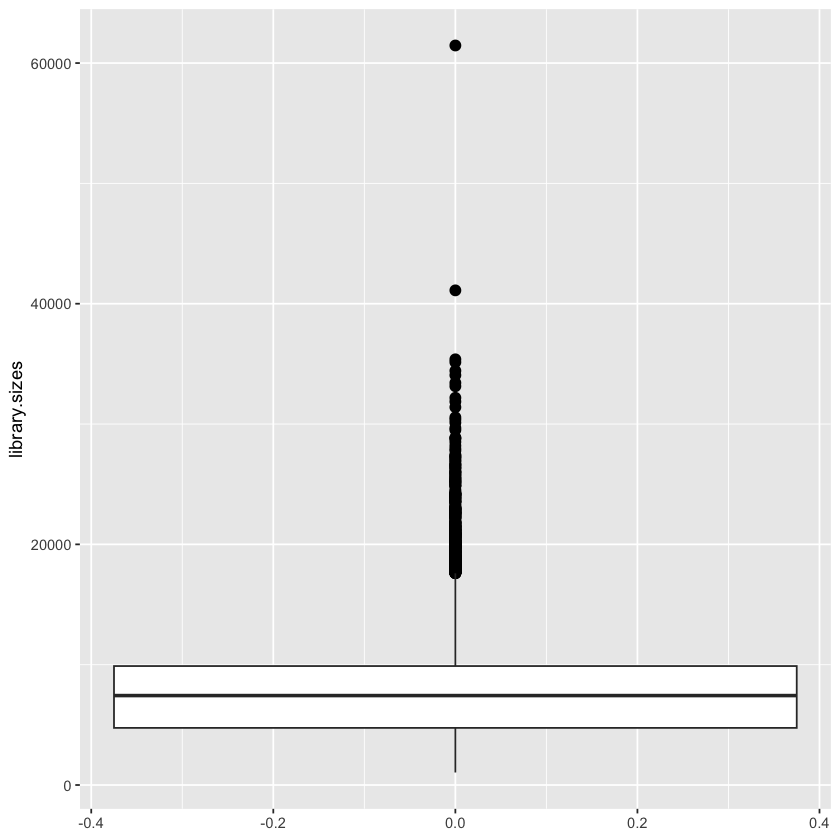

In [ ]:
ggplot(sizes.to.plot, aes(y=library.sizes)) +
geom_boxplot(outlier.colour="black", outlier.shape=16,
             outlier.size=3, notch=FALSE)

This <b style="color:#EB1960">box-and-whiskers plot</b> shows more than two outliers, although there are two cells that are clearly more outlier-y than the rest.  We <em style="color:#C0CF96">should</em> just filter out the two obvious ones, to adhere to the paper, but we'll filter out all of them for the sake of reducing our dataset further.

> An outlier is an observation that is numerically distant from the rest of the data. When reviewing a boxplot, an outlier is defined as a data point that is located outside the fences (“whiskers”) of the boxplot (e.g: outside 1.5 times the interquartile range above the upper quartile and bellow the lower quartile).
> -- <b style="color:#EB1960">R Statistics Blog</b>, [available here](https://www.r-statistics.com/tag/boxplot-outlier/#:~:text=An%20outlier%20is%20an%20observation,and%20bellow%20the%20lower%20quartile).

In [ ]:
offset <- 1.5 * IQR(library.sizes)
quants <- quantile(library.sizes, probs=c(0.25, 0.75))
quants["25%"] <- quants["25%"] - offset
quants["75%"] <- quants["75%"] + offset
outliers.index <- library.sizes < quants["25%"] | library.sizes > quants["75%"]
sum(outliers.index) / length(outliers.index)

[1] 0.02429255

About 2.5% of the data is an outlier!  Which to me feels as if they're not-so-outlier-y after all!  (It goes up to 8% if you use the unfiltered data).

<details>
    <summary><b class="sidequests">Sidequest</b><b style="color:#C0CF96">: What is the largest percent of a dataset that we can make be outliers?</b></summary>

Well, assuming you have a dataset with 4 elements, the IQR is determined by the middle two elements; you can move the outer two as far away from it as possible.  Thus you can force them to be outliers, giving you an outlier percentage of 50%.

This should be optimal, because at least 50% of the data has to lie within the IQR by the definition of the IQR.

</details>

:::{.column-margin}
<b style="color:#C0CF96">50%</b>
:::

Normally I'd be reluctant to remove these, but we have so much data that it'd be nice to shave some of it off^[I know that's not the normal attitude, I just don't want to have to deal with any code that takes longer than a second to run 😅.  Although I chose R over numpy so clearly I don't care that much about speed... Although I guess I'm sure that R can be fast too if you understand how you're supposed to use it.]. 

In [ ]:
filtered.counts.iqr <- filtered.counts.mito.2[, !outliers.index]
filtered.row.info.iqr <- filtered.row.info.mito.2
filtered.col.info.iqr <- filtered.col.info.mito.2[!outliers.index, ]

In [ ]:
dim(filtered.counts.iqr)

[1] 23264 18757

## <b style="color:#537FBF">Normalization</b> and miscellaneous <b style="color:#537FBF">filtering</b>

> <b style="color:#C0CF96">Raw counts</b> of the remaining cells were then <b style="color:#537FBF">normalised</b> using the <b style="color:#537FBF">deconvolution-based method</b> and then <b style="color:#537FBF">log-transformed</b>. We also <b style="color:#537FBF">filtered out</b> the genes with average counts below 0.01 assuming these low-abundance genes to be unreliable for statistical inference.

The question is - what is this <b style="color:#537FBF">deconvolution-based method</b>?  I found [this helpful resource](http://bioconductor.org/books/3.13/OSCA.basic/normalization.html#normalization-by-deconvolution) which describes it well.  Essentially, we want to be able to normalize each cell by their library size, but due to the sparsity of scRNA-seq we need to pool cells together to achieve sufficient mass.  We then "<b style="color:#537FBF">deconvolve</b>" the pooled values to find them on a per-cell basis.

<details>
    <summary><b class="setups">Install</b><b style="color:#C0CF96">: scran</b></summary>

```{R}
BiocManager::install("scran")
```
</details>

In [ ]:
library(scran)

In [ ]:
quick.clusters <- quickCluster(filtered.counts.iqr) 

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


In [ ]:
table(quick.clusters)

quick.clusters
   1    2    3    4    5    6    7    8    9   10   11   12 
1807 1803 3116 1371 2731 1939 1382 1620  150 2608  126  104 

In [ ]:
deconvoluted.counts <- calculateSumFactors(
    filtered.counts.iqr,
    cluster=quick.clusters
)
summary(deconvoluted.counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1732  0.6554  0.9378  1.0000  1.2619  3.5655 

So, in short, the output is a length of factors to divide the cells by.

In [ ]:
dim(filtered.counts.iqr)
length(deconvoluted.counts)

[1] 23264 18757

[1] 18757

In [ ]:
filtered.counts.deconv <- filtered.counts.iqr / deconvoluted.counts
filtered.row.info.deconv <- filtered.row.info.iqr
filtered.col.info.deconv <- filtered.col.info.iqr

Now we'll <b style="color:#537FBF">filter out</b> the genes with small mean counts.

In [ ]:
small.mean.genes.index <- rowMeans(filtered.counts.deconv) < 0.01

In [ ]:
filtered.counts.gene.mean <- filtered.counts.deconv[!small.mean.genes.index, ]
filtered.row.info.gene.mean <- filtered.row.info.deconv[!small.mean.genes.index]
filtered.col.info.gene.mean <- filtered.col.info.deconv

In [ ]:
dim(filtered.counts.gene.mean)

[1] 14872 18757

Finally, we'll <b style="color:#537FBF">log-transform</b> the data.  We'll leave the 0 values as 0 for the sake of our RAM, which means we need to peak into the internal workings of the sparse matrix class.

In [ ]:
class(filtered.counts.gene.mean)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [ ]:
filtered.log.counts <- filtered.counts.gene.mean
filtered.log.row.info <- filtered.row.info.gene.mean
filtered.log.col.info <- filtered.col.info.gene.mean
filtered.log.counts@x <- log(filtered.log.counts@x)

In [ ]:
dim(filtered.log.counts)

[1] 14872 18757

# <b style="color:#A6A440">Highly Variable Genes</b>

> For visualisation and clustering we first selected the <b style="color:#A6A440">Highly Variable Genes</b> (<b style="color:#A6A440">HVGs</b>). For this we first decomposed the variance of expression in each gene to <b style="color:#A6A440">technical</b> and <b style="color:#A6A440">biological components</b> and identified the genes as <b style="color:#A6A440">HVGs</b> where the <b style="color:#A6A440">biological components</b> were significantly greater than zero. 
>
> -- @ovarian-cancer-living-biobank

I'll continue following the [bioconductor guide](http://bioconductor.org/books/3.13/OSCA.basic/feature-selection.html) on this as I've not done it before and would like to do a blog post in the future about it.

In [ ]:
gene.var.data <- modelGeneVar(filtered.log.counts)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 2594 rows containing missing values (`geom_point()`).”


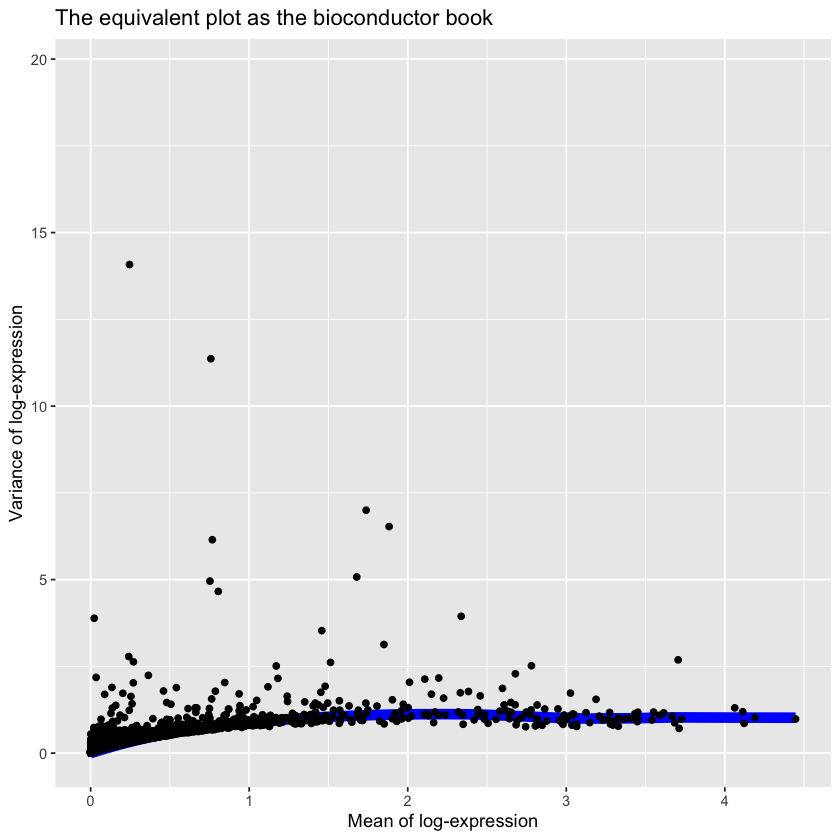

In [ ]:
# Visualizing the fit:
gene.var.metadata <- metadata(gene.var.data)
ggplot(
    data.frame(data.frame(gene.var.metadata$mean)),
    aes(
        x=gene.var.metadata$mean
    ),
) +
    #geom_line(aes(y=gene.var.metadata$var)) +
    stat_function(fun = gene.var.metadata$trend, size=3, colour='blue') + 
    geom_point(aes(y=gene.var.metadata$var)) +
    xlab("Mean of log-expression") +
    ylab("Variance of log-expression") +
    xlim(0, max(gene.var.metadata$mean)) +
    ggtitle("The equivalent plot as the bioconductor book")

We now need to indentify the genes where the <b style="color:#A6A440">biological components</b> is <b style="color:#C0CF96">significantly</b> greater than zero. 

In [ ]:
signif.genes <- gene.var.data$p.value < 0.05
signif.genes[is.na(signif.genes)] <- FALSE
sum(signif.genes)

[1] 6454

In [ ]:
hgv.counts <- filtered.counts.gene.mean[signif.genes,]
hgv.log.counts <- filtered.log.counts[signif.genes,]
hgv.log.row.info <- filtered.log.row.info[signif.genes]
hgv.log.col.info <- filtered.log.col.info

In [ ]:
dim(hgv.log.counts)
dim(hgv.counts)

[1]  6454 18757

[1]  6454 18757

# <b style="color:#EB1960">Figure 5a</b>

> <b style="color:#EB1960">5a)</b> <b style="color:#537FBF">t-Stochastic neighbour embedding (t-SNE)</b> plot showing <b style="color:#537FBF">clustering</b> of single cells from four <b style="color:#A6A440">OCM pairs</b>, with <b style="color:#A6A440">tumour</b> and <b style="color:#A6A440">stromal cells</b> mixed 3:1. 
>
> -- <b style="color:#C0CF96">Caption of</b> <b style="color:#EB1960">Figure 5a</b>

<details>
    <summary><b class="false-starts">False Start</b><b style="color:#C0CF96">: Which cells are <b style="color:#A6A440">tumour</b> and which cells are <b style="color:#A6A440">stromal</b>?</b></summary>

At first I thought it would be easy to tell which cells are which via hand-labeling, however we can see from below that there is no column that corresponds to cell type other `Sample.Characteristic.cell.type.`, and as we'll see it's not a very informative column.

In [ ]:
# To pretty-print `colnames`, we pasted them together with \n
# Note that we need to use `collapse`, not `sep` - I'm pretty
# sure this is because `colnames` is a vector rather than
# multiple arguments, so we need to "collapse" it.
#
# Finally, to render the \ns rather than printing "\n", we need
# to use `cat`.  All-in-all this was far more complicated
# than I thought it would be to get pretty-print working.
cat(
    paste(
        colnames(exp.design.table),
        collapse='\n'
    )
)

Assay
Sample.Characteristic.organism.
Sample.Characteristic.Ontology.Term.organism.
Sample.Characteristic.developmental.stage.
Sample.Characteristic.Ontology.Term.developmental.stage.
Sample.Characteristic.age.
Sample.Characteristic.Ontology.Term.age.
Sample.Characteristic.sex.
Sample.Characteristic.Ontology.Term.sex.
Sample.Characteristic.individual.
Sample.Characteristic.Ontology.Term.individual.
Sample.Characteristic.disease.
Sample.Characteristic.Ontology.Term.disease.
Sample.Characteristic.tumor.grading.
Sample.Characteristic.Ontology.Term.tumor.grading.
Sample.Characteristic.metastatic.site.
Sample.Characteristic.Ontology.Term.metastatic.site.
Sample.Characteristic.organism.part.
Sample.Characteristic.Ontology.Term.organism.part.
Sample.Characteristic.cell.type.
Sample.Characteristic.Ontology.Term.cell.type.
Sample.Characteristic.growth.condition.
Sample.Characteristic.Ontology.Term.growth.condition.
Factor.Value.individual.
Factor.Value.Ontology.Term.individual.

In [ ]:
unique(exp.design.table$Sample.Characteristic.cell.type.)

[1] "mix of stromal fibroblasts and epithelial tumour cells"

Thus every cell is either a <b style="color:#A6A440">stromal fibroblast</b> or an <b style="color:#A6A440">epithelial tumour cell</b>, but we're not given any indication which is which.

> <b style="color:#A6A440">Tumour</b> and <b style="color:#A6A440">stromal</b> cells from the four pairs were mixed 3:1 and analysed in parallel. <b style="color:#537FBF">tSNE plots</b> showed that the majority of cells from each sample formed distinct clusters, whereas smaller fractions formed an overlapping cluster (Fig. 5a). Based on the 3:1 mix, we reasoned that the large distinct clusters represented the <b style="color:#A6A440">tumour cells</b> while the overlapping cluster corresponded to the <b style="color:#A6A440">stromal cells</b>.

So it seems that they didn't keep track of which cells were which (which makes sense, because it'd probably be pretty hard...  Maybe they could have tagged the cells somehow, but maybe that'd be expensive or inaccurate - it's hard for me to say as I don't have the background).  Rather, they just inferred them from <b style="color:#537FBF">tSNE plots</b>.

</details>

::: {.column-margin}
Spoiler: We don't know which!
:::

So we need to run <b style="color:#537FBF">tSNE</b> - ideally, we'd like to use the exact same packages they used for analysis, but they used `scanpy`, a Python package, and this is an R notebook^[If only `sos-notebook` didn't ruin syntax highlighting...  This might require a <b class="sidequests">Sidequest</b> sometime soon.].  So, instead, we'll continue to use the `scran` package.

However, before we run <b style="color:#537FBF">tSNE</b> we have do to (yet another) dimensionality reduction:

> These <b style="color:#A6A440">HVG genes</b> were then used to reduce the dimensions of the dataset using <b style="color:#537FBF">PCA</b>. <b style="color:#537FBF">T-SNE</b> plots were then generated by taking 1–14 components of the <b style="color:#537FBF">PCA</b>. 

In [ ]:
sce.data <- SingleCellExperiment(
    assays=list(
        counts=hgv.counts,
        logcounts=hgv.log.counts
    )
)

In [ ]:
sce.data.pca <- fixedPCA(
    sce.data,
    rank=14,
    subset.row=NULL
)

dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)

dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)



In [ ]:
dim(reducedDim(sce.data.pca, "PCA"))

[1] 18757    14

To run tSNE, we need the `scater` library - note that there is only one "t" in its name!

<details>
    <summary><b class="setups">Install</b><b style="color:#C0CF96">: scater</b></summary>

```{R}
BiocManager::install("scater", type="mac.binary")
```
    
You should probably remove the `mac.binary` bit if not on a Mac, but if you're on a Mac you might need it - without it I got the following uninformative error:
    
```
'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Installing package(s) 'scater'

also installing the dependencies ‘textshaping’, ‘Cairo’, ‘ragg’, ‘ggrastr’


Warning message in install.packages(...):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘Cairo’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘ggrastr’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘scater’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'boot', 'broom', 'cli', 'cpp11', 'crayon', 'desc', 'digest',
  'evaluate', 'forcats', 'generics', 'gtable', 'hms', 'IRkernel', 'isoband',
  'jsonlite', 'mitml', 'nlme', 'pillar', 'pkgload', 'repr', 'rstudioapi',
  'scales', 'statmod', 'stringi', 'stringr', 'survival', 'testthat',
  'viridisLite'
```
</details>

In [ ]:
library(scater)

Warning message:
“package ‘scater’ was built under R version 4.2.2”


In [ ]:
sce.data.tsne <- runTSNE(sce.data.pca, dimred="PCA")

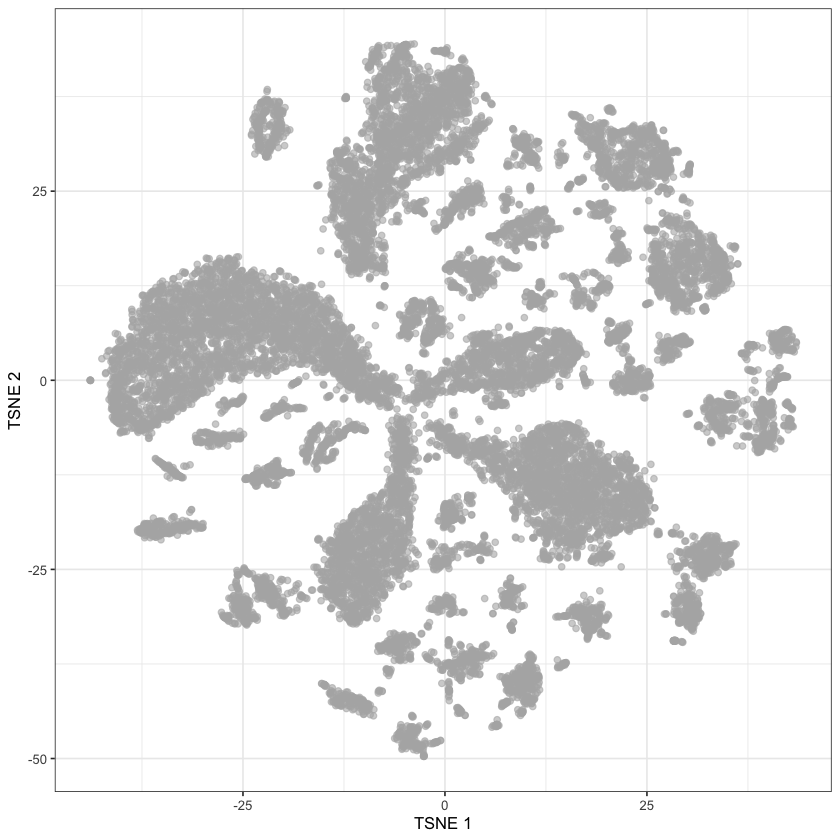

In [ ]:
plotReducedDim(sce.data.tsne, dimred="TSNE")

The only thing remaining is to color by patient.

In [ ]:
exp.design.index <- exp.design.table$Assay %in% hgv.log.col.info$Full.ID

In [ ]:
sce.data.tsne$patient <- exp.design.table[exp.design.index, ]$Sample.Characteristic.individual

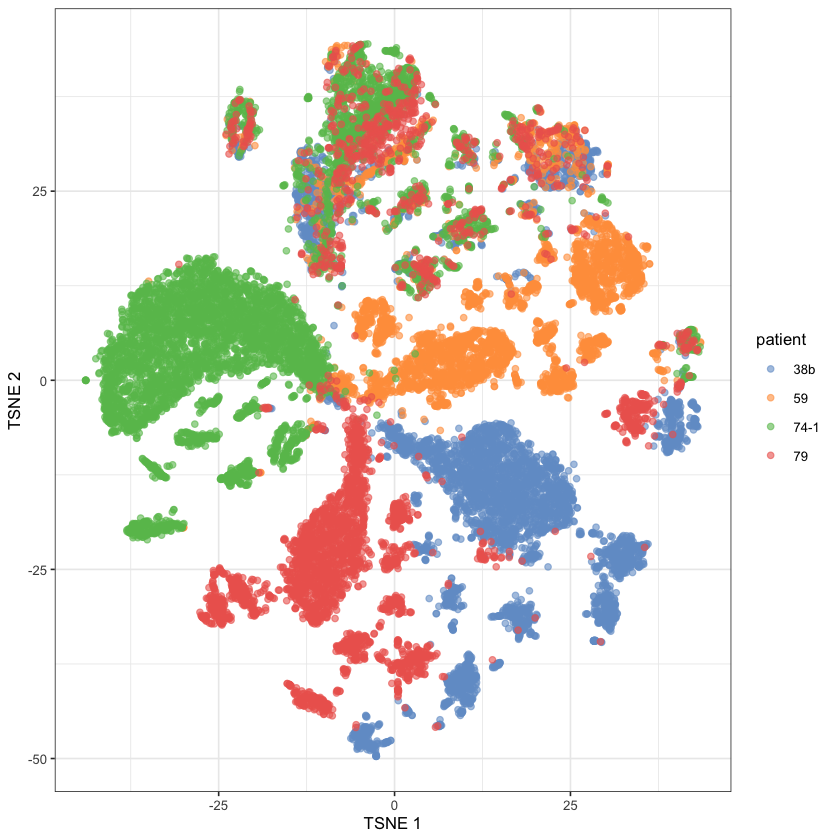

In [ ]:
plotReducedDim(sce.data.tsne, dimred="TSNE", colour_by="patient")

Voilà, it's done!  That took me ages^[Two days, to be precise.  It's 20:54 Jan 21 and I started in the morning of Jan 20 (with many distractions, to be fair)] - mainly because of my lack of experience with R and its ecosystem^[Shoutout to my hour-long adventure trying to install `scater`.].  But, it's done.  Our graph does not look as nice as theirs, but I'm sure it could do if we were to mess with the <b style="color:#537FBF">tSNE</b> parameters.  There are clear patient-related clusters, and then there are sum that are much more mixed which are presumably the <b style="color:#A6A440">stromal</b> clusters.